[View in Colaboratory](https://colab.research.google.com/github/racersmith/active-learner/blob/master/active_learner.ipynb)

# Active Learning

Josh Smith

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Testing ranked based search of loss

In [2]:
n_al = 50
batches_per_search = 5

al_ds_x = np.zeros([n_al, *x_shape])
al_ds_y = np.zeros([n_al, *y_shape])
al_ds_loss = np.full([n_al], -np.inf)

with tf.Session() as sess:
  for _ in range(15):
    for _ in range(batches_per_search):
      x_batch, y_batch, loss_batch = sess.run([batch_x, batch_y, batch_loss])
      add_index = np.argsort(al_ds_loss)[:batch_size]
      batch_mask = al_ds_loss[add_index] < np.squeeze(loss_batch)
      al_ds_x[add_index[batch_mask]] = x_batch[batch_mask]
      al_ds_y[add_index[batch_mask]] = y_batch[batch_mask]
      al_ds_loss[add_index[batch_mask]] = np.squeeze(loss_batch)[batch_mask]

    remove_index = np.argsort(al_ds_loss)[-batch_size:]
    print(np.mean(al_ds_loss[al_ds_loss > 0]), np.mean(al_ds_loss[remove_index]))
    train_x, train_y = al_ds_x[remove_index], al_ds_y[remove_index]
#     print(al_ds_loss[remove_index])
    al_ds_loss[remove_index] = -np.inf

# print(al_ds_loss)

NameError: ignored

In [25]:
class ActiveLearner:
  def __init__(self, al_size, x_example, y_example):
    x_shape = x_example.get_shape().as_list()[1:]
    y_shape = y_example.get_shape().as_list()[1:]
    self.dataset_x = np.zeros((al_size, *x_shape))
    self.dataset_y = np.zeros((al_size, *y_shape))
    self.dataset_l = np.full((al_size), -np.inf)
   
  def update(self, x, y, per_x_loss):
    batch_size = len(x)
    per_x_loss = np.squeeze(per_x_loss)
    add_index = np.argsort(self.dataset_l)[:batch_size]
    batch_mask = self.dataset_l[add_index] < per_x_loss
    self.dataset_x[add_index[batch_mask]] = x[batch_mask]
    self.dataset_y[add_index[batch_mask]] = y[batch_mask]
    self.dataset_l[add_index[batch_mask]] = per_x_loss[batch_mask]
  
  def get_batch(self, batch_size):
    remove_index = np.argsort(self.dataset_l)[-batch_size:]
    x_batch = self.dataset_x[remove_index]
    y_batch = self.dataset_y[remove_index]
    self.dataset_l[remove_index] = -np.inf
    return x_batch, y_batch

In [26]:
n = 100
x_shape = [5, 4, 3]
y_shape = [2, 2]

batch_size = 5

x_data = np.random.normal(0, 1, (n, *x_shape))
y_data = np.random.normal(0, 1, (n, *y_shape))

dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
dataset = dataset.shuffle(n)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()
iterator = dataset.make_one_shot_iterator()
batch_x, batch_y = iterator.get_next()
batch_loss = tf.random_uniform([batch_size, 1], 0, 1)

n_al = 50
batches_per_search = 5

al = ActiveLearner(n_al, batch_x, batch_y)

with tf.Session() as sess:
  for _ in range(50):
    # Search
    for _ in range(batches_per_search):
      x_batch, y_batch, loss_batch = sess.run([batch_x, batch_y, batch_loss])
      al.update(x_batch, y_batch, loss_batch)
    # Get batch
    x_batch, y_batch = al.get_batch(batch_size)
print(al.dataset_l)

[0.81799912 0.79841971       -inf       -inf 0.7896719  0.79465985
 0.78502035       -inf 0.82130826 0.80921316 0.8023212  0.8066771
 0.78921366 0.78844106 0.5641042  0.69598043       -inf 0.8420645
 0.79983258 0.81382966 0.81737113 0.81045985 0.78781474 0.79550552
 0.79622138 0.80655825 0.79491115 0.78633487 0.80485189 0.80221772
 0.80189848       -inf 0.80680847 0.8149482  0.80107236 0.80050588
 0.79841292 0.81026757 0.79776311 0.80582368 0.78741205 0.81396449
 0.81282043 0.80533683 0.81370008 0.78966463 0.79293227 0.7021693
 0.81227612 0.81165612]


In [27]:
def download_dataset():
  mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  train_data = mnist.train.images # Returns np.array
  train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
  
  eval_data = mnist.test.images # Returns np.array
  eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

  return train_data, train_labels, eval_data, eval_labels

train_data, train_labels, eval_data, eval_labels = download_dataset() 

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


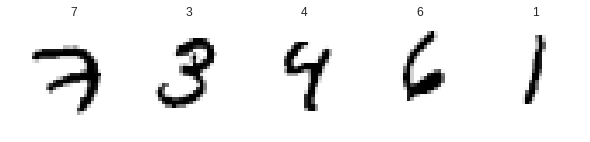

In [28]:
n_plot = 5

plt.subplots(figsize = (2*n_plot, 2))
for i in range(n_plot):
  plt.subplot(1, n_plot, i+1)
  plt.title(train_labels[i])
  plt.imshow(train_data[i].reshape((28, 28)))
  plt.axis('off')
plt.show()

In [29]:
def show_predictions(x, label=None, pred=None):
  n = len(x)
  cols = 5
  rows = n // cols + 1
  i = 0
  plt.subplots(figsize=(1.7*cols, 1.7*rows))
  for i in range(n):
    plt.subplot(rows, cols, i+1)
    if label is not None and pred is not None:
      color='Reds'
      if np.argmax(label[i]) == np.argmax(pred[i]):
        color='Greens'
      plt.imshow(np.squeeze(x[i]), cmap=color)
    else:
      plt.imshow(np.squeeze(x[i]))
    title_str = ""
    if label is not None:
      title_str += "True: {:>6}\n".format(np.argmax(label[i]))
    if pred is not None:
      title_str += "Pred: {:>6}\n".format(np.argmax(pred[i]))
      title_str += "Conf: {:>.2f}".format(np.max(pred[i]))
    plt.title(title_str)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

  
# show_predictions(b_images, b_labels, b_pred)
# plt.imshow(np.squeeze(b_images[0]))
# plt.show()

In [30]:
def smooth(x, k):
  kernel = np.ones(k)/k
  return np.convolve(x, kernel)

def build_dataset(x, y, batch_size):  
  def _preprocess(arr, labels):
    return tf.reshape(arr, (28, 28, 1)), tf.one_hot(labels, 10)
  
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(_preprocess)
  dataset = dataset.shuffle(len(x))
  dataset = dataset.batch(batch_size)
  dataset = dataset.repeat()
  iterator = dataset.make_one_shot_iterator()
  return iterator.get_next()

def conv_bn(input_array, filters):
  x = tf.layers.conv2d(input_array, filters, 3, padding='same', use_bias=False)
  x = tf.layers.batch_normalization(x)
  x = tf.nn.relu(x)
  return x

def conv_bn_pool(input_array, filters):
  x = conv_bn(input_array, filters)
  x = tf.layers.max_pooling2d(x, 2, 2)
  return x

def build_model(image, num_classes):
  with tf.variable_scope('main_model', reuse=False):
    x = conv_bn(image, 8)
    x = conv_bn_pool(x, 16)
    x = conv_bn(x, 16)
    x = conv_bn_pool(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, num_classes)
    logits = tf.reduce_mean(x, axis=(1,2))
    prediction = tf.nn.softmax(logits)
    return logits, prediction

def build_loss(logits, labels):
  per_x_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, 
                                                          labels=labels)
  batch_loss = tf.reduce_sum(per_x_loss)
  return per_x_loss, batch_loss

def build_optimizer(loss, scope='main_model'):
  train_vars = tf.trainable_variables(scope=scope)
  with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    opt = tf.train.AdamOptimizer()
    return opt.minimize(loss, var_list=train_vars)
  
def build_al_model(image):
  with tf.variable_scope('active_learner', reuse=False):
    x = conv_bn(image, 8)
    x = conv_bn_pool(x, 12)
    x = conv_bn(x, 16)
    x = conv_bn_pool(x, 20)
    x = conv_bn(x, 24)
    x = tf.layers.flatten(x)
    logits = tf.layers.dense(x, 1, activation=tf.nn.relu)
    return logits
  
def build_al_loss(logits, per_x_loss):
  logits = tf.reshape(logits, (-1, 1))
  per_x_loss = tf.reshape(per_x_loss, (-1, 1))
  return tf.losses.huber_loss(predictions=logits, labels=per_x_loss)
#   return tf.losses.mean_squared_error(predictions=logits, labels=per_x_loss)

def build_al_optimizer(loss, scope='active_learner'):
  train_vars = tf.trainable_variables(scope=scope)
  with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#     opt = tf.train.GradientDescentOptimizer(learning_rate)
    opt = tf.train.AdamOptimizer()
    return opt.minimize(loss, var_list=train_vars)

In [38]:
def run_og_model(batch_size, n_epochs, batches_per_epoch, show=False):
  tf.reset_default_graph()

  next_images, next_labels = build_dataset(train_data, train_labels, batch_size)
  next_eval_images, next_eval_labels = build_dataset(eval_data, eval_labels, batch_size)
  x = tf.placeholder(tf.float32, [None, 28, 28, 1])
  y = tf.placeholder(tf.int8, [None, 10])

  logits, prediction = build_model(x, 10)
  per_x_loss, batch_loss = build_loss(logits, y)
  main_train_opt = build_optimizer(batch_loss)

  plot_loss = []

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
      for i in range(batches_per_epoch):      
        b_images, b_labels = sess.run([next_images, next_labels])
        _ = sess.run(main_train_opt, feed_dict={x: b_images, y: b_labels}) 

        # Evaluate
        b_images, b_labels = sess.run([next_eval_images, next_eval_labels])
        eval_loss, b_pred = sess.run([batch_loss, prediction], 
                                     feed_dict={x: b_images, y: b_labels})
        plot_loss.append(eval_loss)
        
      if show:
        print("Epoch: {}\tLoss: {:.4f}".format(epoch, eval_loss))
        show_predictions(b_images[:5], b_labels[:5], b_pred[:5])

    eval_loss = []
    for _ in range(len(eval_data)//batch_size):
      b_images, b_labels = sess.run([next_eval_images, next_eval_labels])
      eval_loss.append(sess.run([batch_loss], feed_dict={x: b_images, y: b_labels}))
    eval_loss = np.array(eval_loss).reshape(-1)
    eval_loss = np.mean(eval_loss)
        
  if show:
    plt.figure(figsize=(15,3))    
    plt.plot(plot_loss)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
  print("Session Complete: Loss: {:.4f}".format(eval_loss))
  return plot_loss

In [39]:
def run_al_model(batch_size, n_epochs, batches_per_epoch, searches, warmup_batches, show=False):
  tf.reset_default_graph()

  next_images, next_labels = build_dataset(train_data, train_labels, batch_size)
  next_eval_images, next_eval_labels = build_dataset(eval_data, eval_labels, batch_size)
  x = tf.placeholder(tf.float32, [None, 28, 28, 1])
  y = tf.placeholder(tf.int8, [None, 10])

  logits, prediction = build_model(x, 10)
  per_x_loss, batch_loss = build_loss(logits, y)
  main_train_opt = build_optimizer(batch_loss)

  al_logits = build_al_model(x)
  al_loss = build_al_loss(al_logits, per_x_loss)
  al_train_opt = build_al_optimizer(al_loss)
  al = ActiveLearner(5*batch_size, x, y)

  batch_count = 0
  
  al_plot_loss = []

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
      for _ in range(batches_per_epoch):
        batch_count += 1
        if batch_count > warmup_batches:
          # Search
          for _ in range(searches):
            b_images, b_labels = sess.run([next_images, next_labels])
            batch_x_loss = sess.run(al_logits, 
                                    feed_dict={x: b_images})
            al.update(b_images, b_labels, batch_x_loss)

          # Get batch from active learner
          b_images, b_labels = al.get_batch(batch_size)
        else:
          b_images, b_labels = sess.run([next_images, next_labels])
          batch_x_loss = sess.run(al_logits, feed_dict={x: b_images})
          al.update(b_images, b_labels, batch_x_loss)
          
        ops = [main_train_opt, batch_loss, prediction, al_train_opt, al_loss]
        _, bl, b_pred, _, al_bl = sess.run(ops, 
                                           feed_dict={x: b_images, y: b_labels})

        # Evaluate
        b_images, b_labels = sess.run([next_eval_images, next_eval_labels])
        eval_loss, eval_al_loss, b_pred = sess.run([batch_loss, al_loss, prediction], 
                                           feed_dict={x: b_images, y: b_labels})
        al_plot_loss.append(eval_loss)
      
      if show:
        show_predictions(b_images[:5], b_labels[:5], b_pred[:5])    
        print("Epoch: {}\tLoss: {:.3f}\tAct. Loss: {:.3f}".format(epoch, 
                                                                eval_loss, 
                                                                eval_al_loss))
    eval_loss = []
    for _ in range(len(eval_data)//batch_size):
      b_images, b_labels = sess.run([next_eval_images, next_eval_labels])
      eval_loss.append(sess.run([batch_loss], feed_dict={x: b_images, y: b_labels}))
    eval_loss = np.array(eval_loss).reshape(-1)
    eval_loss = np.mean(eval_loss)
      
  if show:
    plt.figure(figsize=(15,3))    
    plt.plot(al_plot_loss)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
  print("AL Session Complete: Loss: {:.4f}".format(eval_loss))
  return al_plot_loss

In [0]:
batch_size = 25
n_epochs = 10
batches_per_epoch = len(train_data)//batch_size
searches = 4
warmup_batches = 20
log_data = {'og': [], 'al': []}

for i in range(5):
  log_data['og'].append(run_og_model(batch_size, n_epochs, batches_per_epoch, show=False))
  log_data['al'].append(run_al_model(batch_size, n_epochs, batches_per_epoch, searches, warmup_batches, show=False))

Session Complete: Loss: 6.4223
AL Session Complete: Loss: 6.7007
Session Complete: Loss: 0.9522


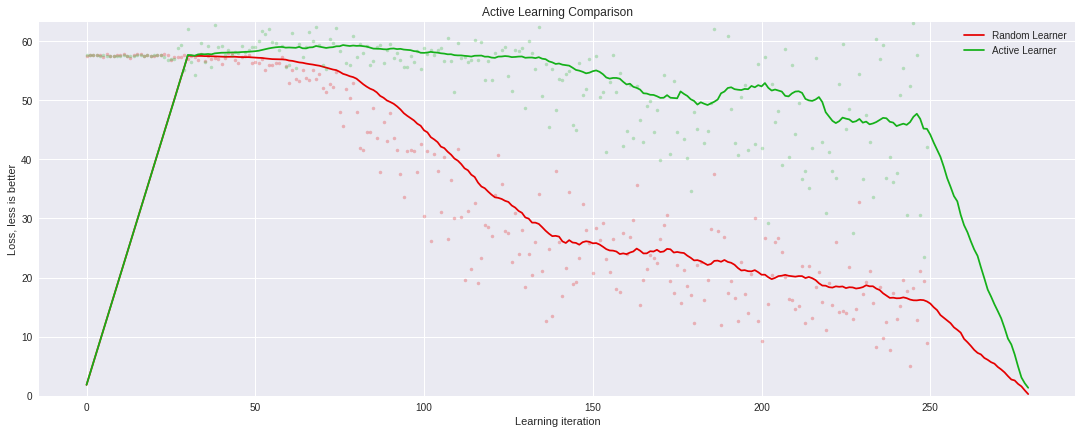

In [40]:
k_smooth = 31
scatter_alpha = 0.25

plt.figure(figsize=(15,6))   
plt.title("Active Learning Comparison")

for og_loss in log_data['og']:
  plt.plot(og_loss, marker='.', linestyle=' ', color='xkcd:red', alpha=scatter_alpha)
  loss_smooth = smooth(og_loss, k_smooth)
  plt.plot(loss_smooth, color='xkcd:red', label='Random Learner')

for al_loss in log_data['al']:
  plt.plot(al_loss, marker='.', linestyle=' ', color='xkcd:green', alpha=scatter_alpha)
  plt.plot(smooth(al_loss, k_smooth), color='xkcd:green', label='Active Learner')

plt.grid(True)
plt.tight_layout()
plt.legend()
plt.ylim(0, 1.1*max(loss_smooth))
plt.ylabel('Loss, less is better')
plt.xlabel('Learning iteration')
plt.show()

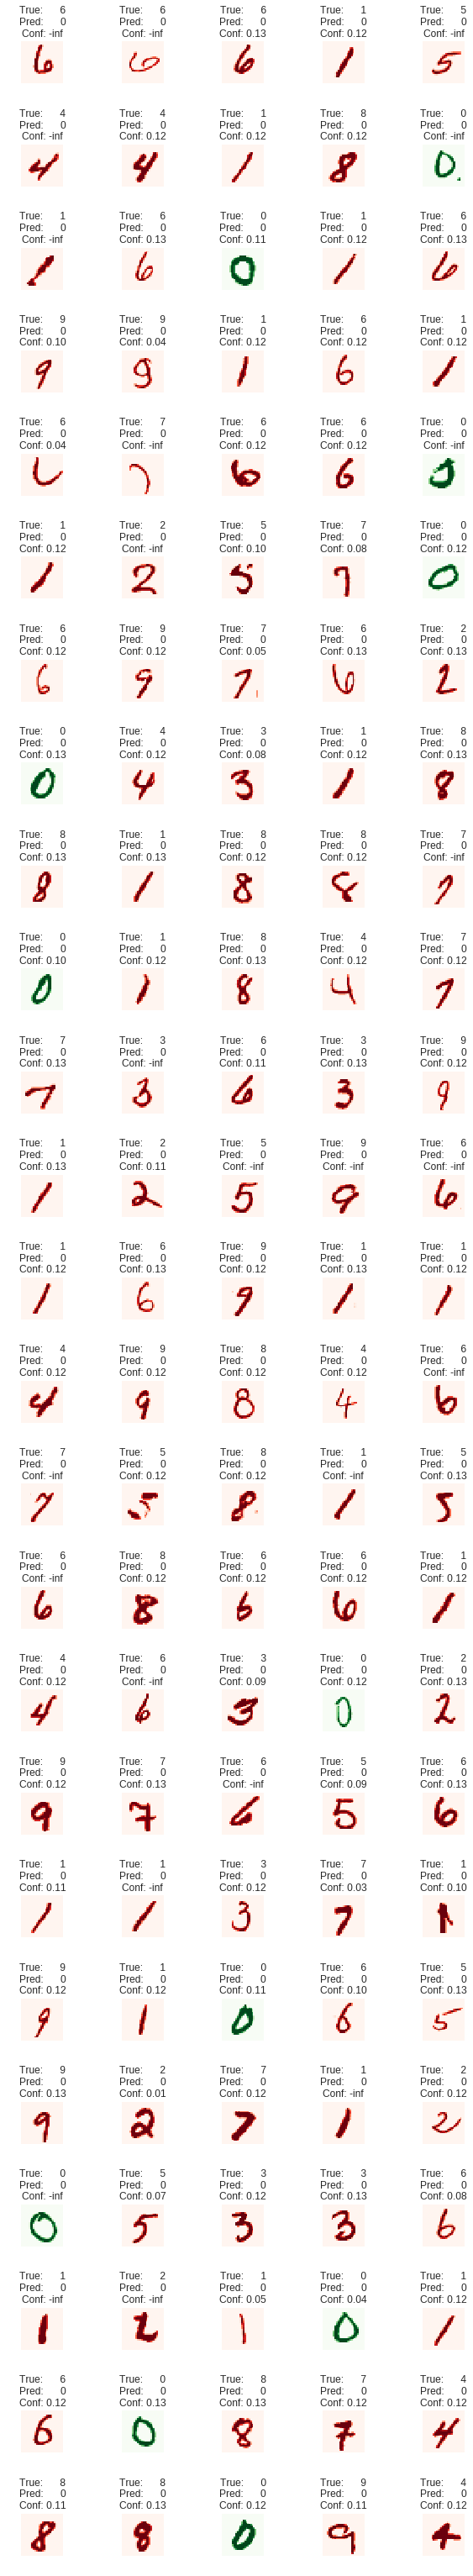

In [13]:
show_predictions(al.dataset_x, al.dataset_y, al.dataset_l)